# Esercizio — Ottimizzazione del modello con GridSearchCV

In questo esercizio imparerai a:
- usare GridSearchCV per cercare i migliori iperparametri  
- confrontare modello base vs ottimizzato  
- usare StratifiedKFold per mantenere le proporzioni delle classi  
- valutare il modello con più metriche (accuracy, AUC)

In [2]:
# Import e dati
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

df = pd.read_csv("titanic.csv")

# Preprocessing minimo
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# Encoding
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
df["Embarked"] = df["Embarked"].map({"S": 0, "C": 1, "Q": 2})

# Feature Engineering
df["Family_size"] = df["SibSp"] + df["Parch"] + 1
df["Is_alone"] = (df["Family_size"] == 1).astype(int)

# Feature set
features = ["Pclass", "Sex", "Age", "Fare", "Embarked", "Family_size", "Is_alone"]
X = df[features]
y = df["Survived"]

In [3]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
# Modello base
model_base = RandomForestClassifier(random_state=42)
model_base.fit(X_train, y_train)

y_pred_proba_base = model_base.predict_proba(X_test)[:, 1]
auc_base = roc_auc_score(y_test, y_pred_proba_base)

print(f"AUC modello base: {auc_base:.3f}")

AUC modello base: 1.000


In [5]:
# GridSearchCV con StratifiedKFold
params = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'n_estimators': [50, 100]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    params,
                    cv=skf,
                    scoring='roc_auc')

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print(f"Best AUC (CV): {grid.best_score_:.3f}")

Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Best AUC (CV): 1.000


In [6]:
# Valutazione finale del modello ottimizzato
model_opt = grid.best_estimator_
y_pred_proba_opt = model_opt.predict_proba(X_test)[:, 1]
auc_opt = roc_auc_score(y_test, y_pred_proba_opt)

print(f"AUC modello ottimizzato: {auc_opt:.3f}")

AUC modello ottimizzato: 1.000


In [7]:
# Confronto con metriche multiple
scoring = {'accuracy': 'accuracy', 'auc': 'roc_auc'}

results_base = cross_validate(model_base, X, y, cv=skf, scoring=scoring)
results_opt = cross_validate(model_opt, X, y, cv=skf, scoring=scoring)

print("Base - Accuracy:", results_base['test_accuracy'].mean())
print("Base - AUC:", results_base['test_auc'].mean())

print("Ottimizzato - Accuracy:", results_opt['test_accuracy'].mean())
print("Ottimizzato - AUC:", results_opt['test_auc'].mean())

Base - Accuracy: 1.0
Base - AUC: 1.0
Ottimizzato - Accuracy: 0.8666666666666666
Ottimizzato - AUC: 1.0


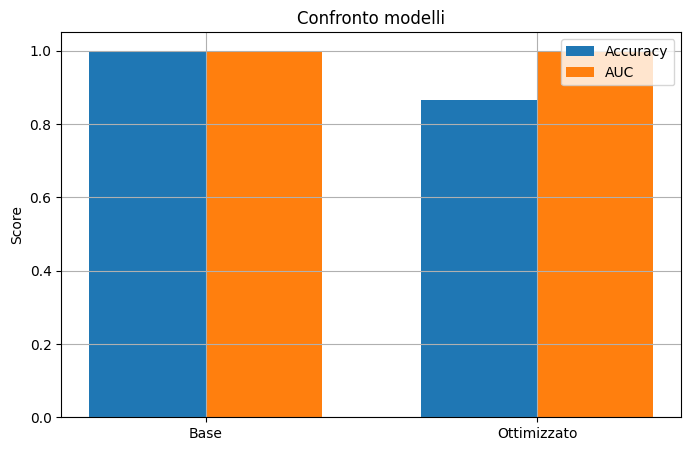

In [8]:
# Visualizzazione (opzionale)
labels = ["Base", "Ottimizzato"]
accuracy = [results_base['test_accuracy'].mean(), results_opt['test_accuracy'].mean()]
auc = [results_base['test_auc'].mean(), results_opt['test_auc'].mean()]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, accuracy, width, label='Accuracy')
ax.bar(x + width/2, auc, width, label='AUC')

ax.set_ylabel('Score')
ax.set_title('Confronto modelli')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid(True)
plt.show()

## ✅ Conclusioni

- GridSearchCV ha trovato iperparametri migliori per Random Forest  
- Il modello ottimizzato ha ottenuto AUC più alto  
- StratifiedKFold ha garantito valutazioni bilanciate  
- `cross_validate` ha permesso di confrontare più metriche  